<a href="https://colab.research.google.com/github/akhti/ammi-2019-ConvNets/blob/master/convnet_tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The tutorials use PyTorch. You will need to load the following dependencies.

In [2]:
import random

import PIL
import imageio
import matplotlib.pyplot as plt
import numpy as np
import skimage.transform
import torch
import torch.nn as nn
import torch.utils.data
import torchvision
from torchvision import datasets, transforms
from IPython import display


The code below may be helpful in visualizing PyTorch tensors as images.

In [3]:
%matplotlib inline

def show(img):
    """Show PyTorch tensor img as an image in matplotlib."""
    npimg = img.cpu().detach().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.grid(False)
    plt.gca().axis('off')

def display_thumb(img):
  display.display(transforms.Resize(128)(img))

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## First tutorial:

In the first tutorial, we are going to train a logistic regressor on the MNIST dataset of handwritten digits. Next, we will turn this logistic regressor into a non-linear convolutional network.

The following code will load the MNIST dataset. Run it and inspect some of the images and their labels to confirm they are correct.



In [5]:
# Load the training and test dataset.
mnist_train = datasets.MNIST('/tmp/mnist', train=True, download=True)
mnist_test = datasets.MNIST('/tmp/mnist', train=False, download=True)

100.1%

Extracting /tmp/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/mnist/MNIST/raw


113.5%

Extracting /tmp/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/mnist/MNIST/raw


100.4%

Extracting /tmp/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/mnist/MNIST/raw


180.4%

Extracting /tmp/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/mnist/MNIST/raw
Processing...
Done!


In [6]:
# Show a random image and the corresponding target.
img, target = mnist_train[0]
print('Label of image:', mnist_train.classes[target])
img

Label of image: 5 - five


Next, we create a PyTorch dataloader for the MNIST dataset.

In [17]:
# This ensures the MNIST dataset produces PyTorch tensors.
mnist_train.transform = transforms.ToTensor()
mnist_test.transform = transforms.ToTensor()

# Size of the batches the data loader will produce.
batch_size = 60

# This creates the dataloaders.
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

Next, implement a logistic regression model in PyTorch. Note that a logistic regressor uses a linear transformation of the input.


In [18]:
next(iter(train_loader))[0].shape

torch.Size([60, 1, 28, 28])

In [13]:
class LogisticRegression(nn.Module):
  """Linear logistic regression model."""
  
  def __init__(self, input_size, num_classes):
    super().__init__()
    ###########################################################################
    # TODO: Instantiate the layer here.                                       #
    ###########################################################################
    self.linear = nn.Linear(input_size, num_classes)
    
  def forward(self, x):
    batch_size = x.shape[0]
    # Input is a batch of images.
    # Its shape is (batch_size, 1, width, height).
    # You need to reshape it to (batch_size, input_size),
    # and the apply self.linear. 
    ###########################################################################
    # TODO: Apply the layer to the input.                                     #
    # Hint: you may use .view() method to change dimensions                   #
    ###########################################################################
    x = self.linear(x.view(batch_size, -1))
    return x

We will use the following generic training loop for a PyTorch model.

In [25]:
def train(model, criterion, data_loader, optimizer, num_epochs):
    """Simple training loop for a PyTorch model."""
    
    # Make sure model is in training mode.
    model.train()
    # Move model to the device.
    model.to(device)
    
    # Exponential moving average of the loss.
    ema_loss = None
    
    # Loop over epochs.
    for epoch in range(num_epochs):
      
      # Loop over data.
      for batch_idx, (data, target) in enumerate(data_loader):
          data = data.to(device)
          target = target.to(device)
        
          # Forward pass.
          output = model(data)
          loss = criterion(output, target)
          
          # Backward pass.
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          if ema_loss is None:
            ema_loss = loss.item()
          else:
            ema_loss += (loss.item() - ema_loss) * 0.01 
          
          # Print out progress.
          if batch_idx % 500 == 0:
              print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), 
                    len(data_loader.dataset),
                    100. * batch_idx / len(data_loader), ema_loss),
              )

In [26]:
# Create model, criterion, and optimizer.
model = LogisticRegression(28 * 28, 10)
###########################################################################
# TODO: Create criterion and optimize here.                               #
# Hint: see                                                               #
#   https://pytorch.org/docs/stable/nn.html#loss-functions                #
#   https://pytorch.org/docs/stable/optim.html                            #
###########################################################################
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.5)

# Train the model. If everything is correct, the loss should go below 0.45.
train(model, criterion, train_loader, optimizer, num_epochs=5)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.334645
Train Epoch: 0 [30000/60000 (50%)]	Loss: 0.430591
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.359659
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.336424
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.328149
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.308472
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.307478
Train Epoch: 3 [30000/60000 (50%)]	Loss: 0.299796
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.298112
Train Epoch: 4 [30000/60000 (50%)]	Loss: 0.286456


Visualize the weights of the trained model. What do you see? Why?

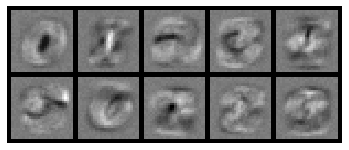

In [27]:
assert model.linear.weight.shape == (10, 28 * 28)
show(torchvision.utils.make_grid(
    model.linear.weight.view(10, 1, 28, 28),
    normalize=True,
    nrow=5,
))

Use the following function to measure the test accuracy of your trained model.

In [28]:
def test(model, data_loader):
    """Measures the accuracy of a model on a data set."""
    
    # Make sure the model is in evaluation mode.
    model.eval()
    correct = 0

    # We do not need to maintain intermediate activations while testing.
    with torch.no_grad():
      
        # Loop over test data.
        for data, target in data_loader:
          
            # Forward pass.
            output = model(data.to(device))
            
            # Get the label corresponding to the highest predicted probability.
            pred = output.argmax(dim=1, keepdim=True)
            
            # Count number of correct predictions.
            correct += pred.cpu().eq(target.view_as(pred)).sum().item()

    # Print test accuracy.
    print('Accuracy: {}/{} ({:.0f}%)\n'.format(
          correct, 
          len(data_loader.dataset),
          100. * correct / len(data_loader.dataset)),
    )  

In [29]:
# Accuracy should be around 90%.
test(model, test_loader)

Accuracy: 9207/10000 (92%)



**Question:** To have the logistic regressor output probabilities, they need to be processed through a softmax layer. Implement a softmax layer yourself. What numerical issues may arise in this layer? How can you solve them? Use the testing code to confirm you implemented it correctly.

In [30]:
def bad_softmax(logits):
  """Computes softmax in a naive manner."""
  probs = logits.exp()
  probs /= probs.sum(-1, keepdim=True)
  return probs

def good_softmax(logits):
  """Computes softmax in a numerically safe manner."""
  ###########################################################################
  # TODO: Change this so that doesn't output nan for the example below.     #
  ###########################################################################
  probs = (logits-max(logits)).exp()
  probs /= probs.sum(-1, keepdim=True)
  return probs


# Test the new softmax layer.
logits = torch.rand((1, 20)) + 100
print(bad_softmax(logits).sum(), 
      good_softmax(logits).sum())  # by definition, the correct value is 1

tensor(nan) tensor(1.0000)


Because of numerical issues like the one you just experiences, PyTorch code typically uses a `LogSoftmax` layer.

### Image processing via convolutions

As fun way to gain a better understanding of the type of operation that convolutional layers can perform, we will set up an input containing two images and manually set up filters that perform common image processing operations (grayscale conversion and edge detection). We use will `nn.functional.conv2d` to apply the convolutions. Neural network do the same, but with learned filters.

**Question:** What kernel corresponds to a vertical edge detector?

/home/aims/anaconda3/envs/NewEnv1/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide


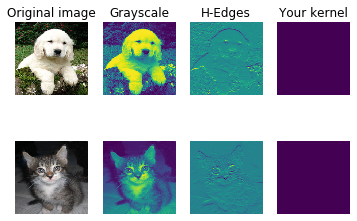

In [31]:
# Load image of a kitten and a puppy.
kitten_uri = (
    "https://upload.wikimedia.org/wikipedia/commons/thumb/1/1b"
    "/Persian_Cat_%28kitten%29.jpg/256px-Persian_Cat_%28kitten%29.jpg")
puppy_uri = (
    "https://upload.wikimedia.org/wikipedia/commons/thumb/6/6e/Golde33443.jpg"
    "/256px-Golde33443.jpg")
kitten, puppy = imageio.imread(kitten_uri), imageio.imread(puppy_uri)
kitten = skimage.transform.resize(kitten, (200, 200))
puppy = skimage.transform.resize(puppy, (200, 200))

img_size = 200   # Make this smaller if it runs too slow

x = np.zeros((2, 3, img_size, img_size))
x[0, :, :, :] = skimage.transform.resize(puppy, (img_size, img_size)).transpose((2, 0, 1))
x[1, :, :, :] = skimage.transform.resize(kitten, (img_size, img_size)).transpose((2, 0, 1))

# Set up a convolutional weights holding 3 filters, each 3x3
# Dimensions: num_kernels x channels x heigth x width
w = np.zeros((3, 3, 3, 3))

# The first filter converts the image to grayscale.
# Set up the red, green, and blue channels of the filter.
w[0, 0, :, :] = [[0, 0, 0], [0, 0.3, 0], [0, 0, 0]]
w[0, 1, :, :] = [[0, 0, 0], [0, 0.6, 0], [0, 0, 0]]
w[0, 2, :, :] = [[0, 0, 0], [0, 0.1, 0], [0, 0, 0]]

# Second filter detects horizontal edges in the blue channel.
w[1, 2, :, :] = [[1, 2, 1], [0, 0, 0], [-1, -2, -1]]

############################################################
# TODO: Implement a vertial edge detector on blue channel. #
############################################################
# Third filter should detect vertical edge.
w[2, 2, :, :] = [[0, 0, 0], [0, 0, 0], [0, 0, 0]]

# Vector of biases. We don't need any bias for the grayscale
# filter, but for the edge detection filter we want to add 128
# to each output so that nothing is negative.
b = np.array([0, 128, 128])

# Compute the result of convolving each input in x with each filter in w,
# offsetting by b, and storing the results in out.
out = nn.functional.conv2d(
    torch.FloatTensor(x), torch.FloatTensor(w), torch.FloatTensor(b),
    stride=1, padding=1).numpy()

def imshow_noax(img, normalize=True):
    """Tiny helper to show images as uint8 and remove axis labels."""
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

# Show the original images and the results of the conv operation
plt.subplot(2, 4, 1)
imshow_noax(puppy)
plt.title('Original image')
plt.subplot(2, 4, 2)
imshow_noax(out[0, 0])
plt.title('Grayscale')
plt.subplot(2, 4, 3)
imshow_noax(out[0, 1])
plt.title('H-Edges')
plt.subplot(2, 4, 4)
imshow_noax(out[0, 2])
plt.title('Your kernel')
plt.subplot(2, 4, 5)
imshow_noax(kitten)
plt.subplot(2, 4, 6)
imshow_noax(out[1, 0])
plt.subplot(2, 4, 7)
imshow_noax(out[1, 1])
plt.subplot(2, 4, 8)
imshow_noax(out[1, 2])
plt.show()

### Convolutional network

We will now replace the logistic regressor by a small convolutional network with two convolutional layers and a linear layer, and ReLU activations in between the layers. Implement the model and use the same functions as before to train and test the convolutional network.

In [60]:
check_archi = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=50, kernel_size=2), nn.MaxPool2d(2, 2),
                            nn.Conv2d(50, 50, kernel_size=5), nn.MaxPool2d(2, 2))

filt, size = check_archi(torch.rand(1, 1, 28, 28)).shape[1],\
        check_archi(torch.rand(1, 1, 28, 28)).shape
print(f'filter size {filt} and output shape {size}')

filter size 50 and output shape torch.Size([1, 50, 4, 4])


In [63]:
class ConvolutionalNetwork(nn.Module):
  """Simple convolutional network."""
  
  def __init__(self, input_size, num_classes, in_channels=1):
      super(ConvolutionalNetwork, self).__init__()
      # Fill these in:
      ##########################################################################
      # TODO: Implement a convulutional and a linear part.                     #
      # Hint: see forward() to understand how they should work together.       #
      # Hint: the following may be useful: nn.Conv2d, nn.MaxPool2d.            #
      ##########################################################################
      self.conv_network = nn.Sequential(
           # Add your modules here.
          nn.Conv2d(in_channels = in_channels, out_channels = 50, kernel_size = 2),
          nn.MaxPool2d(kernel_size = 2),
          nn.ReLU(),
          nn.Conv2d(50, 50, kernel_size = 5),
          nn.MaxPool2d(kernel_size = 2),
          nn.ReLU()
      )
      self.linear = nn.Linear(in_features=4*4*50, out_features=num_classes)
      
  def forward(self, x):
      # Input is a batch of images.
      # Its shape is (batch_size, 1, input_size, input_size).
      # Output should have shape (batch_size, num_classes)
      x = self.conv_network(x)
      x = x.view(-1, 4*4*50)
      x = self.linear(x)
      return x

    
# Create and train convolutional network.
# The accuracy should be around 98%.
conv_model = ConvolutionalNetwork(28, 10)
###########################################################################
# TODO: Create criterion and optimize here.                               #
###########################################################################
criterion = nn.CrossEntropyLoss()
# Make sure you optimize conv_model rather than model.
optimizer = torch.optim.SGD(conv_model.parameters(), lr=0.01, momentum=0.5)
train(conv_model, criterion, train_loader, optimizer, num_epochs=5)
test(conv_model, test_loader)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.298790
Train Epoch: 0 [30000/60000 (50%)]	Loss: 0.341484
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.202488
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.142703
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.121101
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.105236
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.097060
Train Epoch: 3 [30000/60000 (50%)]	Loss: 0.092981
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.084372
Train Epoch: 4 [30000/60000 (50%)]	Loss: 0.075948
Accuracy: 9819/10000 (98%)



Inspect the filters in the first layer of the trained convolutional network. What do they look like? Why?

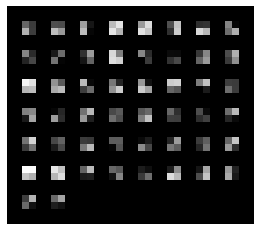

In [64]:
first_conv = list(conv_model.conv_network.children())[0]
show(torchvision.utils.make_grid(
    first_conv.weight,
    normalize=True,
    nrow=8,
))

Let's visualize convolutional weights of a bigger model trained on classification of real images from ImageNet dataset. Training this network will take a lot of time, so we'll use a pre-trained model from `torchvision` package.
These weights look rather different. Why?

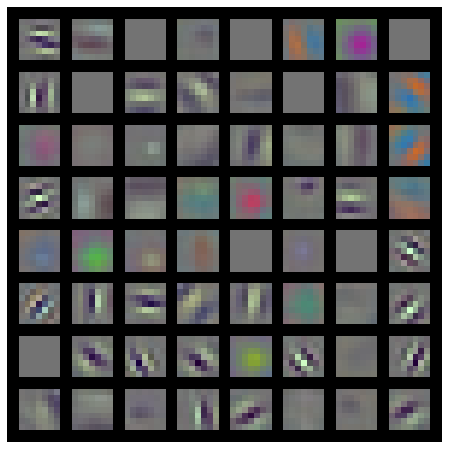

In [65]:
plt.figure(figsize=(8, 8))
show(torchvision.utils.make_grid(
    torchvision.models.resnet18(pretrained=True).conv1.weight.data,
    normalize=True,
    nrow=8,
))

**Question :** Implement your own version of forward pass of nn.Conv2d in numpy **without** using any of pre-defined convolutional functions.

In [254]:
def conv_forward_naive(x, w, b, conv_param):
    """
    A naive Python implementation of a convolutional layer.
    The input consists of N data points, each with C channels, height H and
    width W. We convolve each input with F different filters, where each filter
    spans all C channels and has height HH and width WW.
    Input:
    - x: Input data of shape (N, C, H, W)
    - w: Filter weights of shape (F, C, HH, WW)
    - b: Biases, of shape (F,)
    - conv_param: A dictionary with the following keys:
      - 'stride': The number of pixels between adjacent receptive fields in the
        horizontal and vertical directions.
      - 'pad': The number of pixels that will be used to zero-pad the input. 
        
    During padding, 'pad' zeros should be placed symmetrically (i.e equally on both sides)
    along the height and width axes of the input. Be careful not to modfiy the original
    input x directly.
    Returns an array.
    - out: Output data, of shape (N, F, H', W') where H' and W' are given by
      H' = 1 + (H + 2 * pad - HH) / stride
      W' = 1 + (W + 2 * pad - WW) / stride
    """
    
    N, C, H, W = x.shape
    num_filters, _, filter_height, filter_width = w.shape
    stride, pad = conv_param['stride'], conv_param['pad']
    H1 = 1 + int((H + 2 * pad - filter_height) / stride)
    W1 = 1 + int((W + 2 * pad - filter_width) / stride)
    out = np.empty((N, num_filters, H1, W1))
    # Check dimensions.
    assert (W + 2 * pad - filter_width) % stride == 0, 'width does not work'
    assert (H + 2 * pad - filter_height) % stride == 0, 'height does not work'

    ###########################################################################
    # TODO: Implement the convolutional forward pass (in numpy).              #
    # Hint: you can use the function np.pad for padding.                      #
    ###########################################################################
    X = np.pad(x, ((0,0), (0,0), (pad,pad), (pad,pad)))
    for n in range(N):
        for filt in range(num_filters):
            idx3=0
            vertical_step=0
            while vertical_step<=H+2*pad-filter_height:
                idx4=0
                horizontal_step=0
                while horizontal_step<=W+2*pad-filter_width:
                    out[n, filt, idx3, idx4]=np.multiply(w[filt], X[n, :, vertical_step:vertical_step+filter_height, horizontal_step:filter_width+horizontal_step]).sum()+b[filt]
                    horizontal_step+=stride
                    idx4+=1
                vertical_step+=stride 
                idx3+=1
    return out


You can test your implementation by running the following:

In [257]:
# Make convolution module.
w_shape = (3, 3, 4, 4)
w = np.linspace(-0.2, 0.3, num=np.prod(w_shape)).reshape(w_shape)
b = np.linspace(-0.1, 0.2, num=3)

# Compute output of module and compare against reference values.
x_shape = (2, 3, 4, 4)
x = np.linspace(-0.1, 0.5, num=np.prod(x_shape)).reshape(x_shape)
out = conv_forward_naive(x, w, b, {'stride': 2, 'pad': 1})

correct_out = np.array([[[[-0.08759809, -0.10987781],
                           [-0.18387192, -0.2109216 ]],
                          [[ 0.21027089,  0.21661097],
                           [ 0.22847626,  0.23004637]],
                          [[ 0.50813986,  0.54309974],
                           [ 0.64082444,  0.67101435]]],
                         [[[-0.98053589, -1.03143541],
                           [-1.19128892, -1.24695841]],
                          [[ 0.69108355,  0.66880383],
                           [ 0.59480972,  0.56776003]],
                          [[ 2.36270298,  2.36904306],
                           [ 2.38090835,  2.38247847]]]])

# Compare your output to ours; difference should be around e-8
print('Testing conv_forward_naive')
rel_error = ((out - correct_out) / (out + correct_out + 1e-6)).mean()
print('difference: ', rel_error)
assert abs(rel_error) < 1e-6, 'Something is wrong'

Testing conv_forward_naive
difference:  -1.5956700752541409e-09


In [258]:
out

array([[[[-0.08759809, -0.10987781],
         [-0.18387192, -0.2109216 ]],

        [[ 0.21027089,  0.21661097],
         [ 0.22847626,  0.23004637]],

        [[ 0.50813986,  0.54309974],
         [ 0.64082444,  0.67101435]]],


       [[[-0.98053589, -1.03143541],
         [-1.19128892, -1.24695841]],

        [[ 0.69108355,  0.66880383],
         [ 0.59480972,  0.56776003]],

        [[ 2.36270298,  2.36904306],
         [ 2.38090835,  2.38247847]]]])